Multi-Driver Telemetry Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior to applying machine learning models to multi-driver behavior analysis results. Additional descriptive statistics are added to single driver data frames that will then be concatenated and used as input for machine learning models.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.ERROR)

In this section, I import Python libraries for data visualization, numerical analysis, and working with the Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

These session parameters were chosen to best match Tier 1 controls:

- Weather: Abu Dhabi (clear, dry conditions)
- Max Speed: C5 Ultra Soft Tires
- Minimize Outliers: Qualifying Sessions (Q3 & Q2)
- Traffic: Avoid tow laps to avoid slipstream bias
- Corner Analysis → Isolates driver techniques

In [3]:
year = 2024
grand_prix = f1_constants.F1Constants.LOCATIONS["Abu Dhabi"]
session_type = f1_constants.F1Constants.SESSIONS["Q"]

session = f1_data.F1Session(year, grand_prix, session_type)

qualifying_sessions = ['q2', 'q3']

req         WARNING 	DEFAULT CACHE ENABLED! (716.91 MB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '55', '27', '1', '10', '63', '14', '77', '11', '22', '30', '18', '16', '20', '23', '24', '44', '43', '61']


All drivers who participated in the specific location's Q2 and Q3 sessions will be analyzed and assigned variables to be identified by their three-letter name code. Q3 data will be used for each driver whenever available; otherwise, Q2 data will be selected.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

In [4]:
# driver constants
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
perez = f1_constants.F1Constants.DRIVERS["Sergio Perez"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
bottas = f1_constants.F1Constants.DRIVERS["Valtteri Bottas"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]
magnussen = f1_constants.F1Constants.DRIVERS["Kevin Magnussen"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]
# steering = f1_constants.F1Constants.TELEMETRY_COLUMNS["Steering Wheel Angle (°)"]

The code below retrieves circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

# 16 --> 2500, 12 --> 1800
critical_turn = [16]
radius = 2500

For each driver, the telemetry from their fastest qualifying laps are isolated by filtering based on sector timestamps. These sector datasets are then cleaned, enriched with derived features, and filtered by turn to focus on the segments most informative for analyzing driver behavior and responses at brake-intensive areas.

Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Lando Norris

In [6]:
# Norris
norris_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=norris,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
norris_fastest_q3_corner_telemetry = norris_df[(norris_df['qualifying_session'] == 'q3') & (norris_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
norris_second_fastest_q3_corner_telemetry = norris_df[(norris_df['qualifying_session'] == 'q3') & (norris_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
norris_fastest_q2_corner_telemetry = norris_df[(norris_df['qualifying_session'] == 'q2') & (norris_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
norris_second_fastest_q2_corner_telemetry = norris_df[(norris_df['qualifying_session'] == 'q2') & (norris_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [7]:
# telemetry analysis for q3 laps - Norris
norris_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(norris_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
norris_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(norris_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Norris
norris_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(norris_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
norris_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(norris_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

norris_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(norris_fastest_q3_feature_telemetry)])
norris_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(norris_second_fastest_q3_feature_telemetry)])
norris_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(norris_fastest_q2_feature_telemetry)])
norris_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(norris_second_fastest_q2_feature_telemetry)])

The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [8]:
# exploratory data analysis summary for fastest q3 laps - Norris
norris_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(norris_fastest_q3_feature_telemetry, norris, critical_turn[0], norris_fastest_q3_summary)
norris_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(norris_second_fastest_q3_feature_telemetry, norris, critical_turn[0], norris_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Norris
norris_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(norris_fastest_q2_feature_telemetry, norris, critical_turn[0], norris_fastest_q2_summary)
norris_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(norris_second_fastest_q2_feature_telemetry, norris, critical_turn[0], norris_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Oscar Piastri.

In [9]:
# Piastri
piastri_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=piastri,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
piastri_fastest_q3_corner_telemetry = piastri_df[(piastri_df['qualifying_session'] == 'q3') & (piastri_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
piastri_second_fastest_q3_corner_telemetry = piastri_df[(piastri_df['qualifying_session'] == 'q3') & (piastri_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
piastri_fastest_q2_corner_telemetry = piastri_df[(piastri_df['qualifying_session'] == 'q2') & (piastri_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
piastri_second_fastest_q2_corner_telemetry = piastri_df[(piastri_df['qualifying_session'] == 'q2') & (piastri_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [10]:
# telemetry analysis for q3 laps - Piastri
piastri_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(piastri_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
piastri_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(piastri_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Piastri
piastri_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(piastri_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
piastri_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(piastri_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

piastri_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(piastri_fastest_q3_feature_telemetry)])
piastri_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(piastri_second_fastest_q3_feature_telemetry)])
piastri_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(piastri_fastest_q2_feature_telemetry)])
piastri_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(piastri_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [11]:
# exploratory data analysis summary for fastest q3 laps - Piastri
piastri_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(piastri_fastest_q3_feature_telemetry, piastri, critical_turn[0], piastri_fastest_q3_summary)
piastri_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(piastri_second_fastest_q3_feature_telemetry, piastri, critical_turn[0], piastri_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Piastri
piastri_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(piastri_fastest_q2_feature_telemetry, piastri, critical_turn[0], piastri_fastest_q2_summary)
piastri_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(piastri_second_fastest_q2_feature_telemetry, piastri, critical_turn[0], piastri_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Max Verstappen.

In [12]:
# Verstappen
verstappen_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=verstappen,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
verstappen_fastest_q3_corner_telemetry = verstappen_df[(verstappen_df['qualifying_session'] == 'q3') & (verstappen_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
verstappen_second_fastest_q3_corner_telemetry = verstappen_df[(verstappen_df['qualifying_session'] == 'q3') & (verstappen_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
verstappen_fastest_q2_corner_telemetry = verstappen_df[(verstappen_df['qualifying_session'] == 'q2') & (verstappen_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
verstappen_second_fastest_q2_corner_telemetry = verstappen_df[(verstappen_df['qualifying_session'] == 'q2') & (verstappen_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [13]:
# telemetry analysis for q3 laps - Verstappen
verstappen_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(verstappen_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
verstappen_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(verstappen_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Verstappen
verstappen_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(verstappen_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
verstappen_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(verstappen_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

verstappen_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(verstappen_fastest_q3_feature_telemetry)])
verstappen_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(verstappen_second_fastest_q3_feature_telemetry)])
verstappen_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(verstappen_fastest_q2_feature_telemetry)])
verstappen_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(verstappen_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [14]:
# exploratory data analysis summary for fastest q3 laps - Verstappen
verstappen_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(verstappen_fastest_q3_feature_telemetry, verstappen, critical_turn[0], verstappen_fastest_q3_summary)
verstappen_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(verstappen_second_fastest_q3_feature_telemetry, verstappen, critical_turn[0], verstappen_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Verstappen
verstappen_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(verstappen_fastest_q2_feature_telemetry, verstappen, critical_turn[0], verstappen_fastest_q2_summary)
verstappen_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(verstappen_second_fastest_q2_feature_telemetry, verstappen, critical_turn[0], verstappen_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Sergio Perez.

In [15]:
# Perez
perez_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=perez,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
perez_fastest_q3_corner_telemetry = perez_df[(perez_df['qualifying_session'] == 'q3') & (perez_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
perez_second_fastest_q3_corner_telemetry = perez_df[(perez_df['qualifying_session'] == 'q3') & (perez_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
perez_fastest_q2_corner_telemetry = perez_df[(perez_df['qualifying_session'] == 'q2') & (perez_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
perez_second_fastest_q2_corner_telemetry = perez_df[(perez_df['qualifying_session'] == 'q2') & (perez_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [16]:
# telemetry analysis for q3 laps - Perez
perez_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(perez_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
perez_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(perez_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Perez
perez_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(perez_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
perez_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(perez_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

perez_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(perez_fastest_q3_feature_telemetry)])
perez_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(perez_second_fastest_q3_feature_telemetry)])
perez_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(perez_fastest_q2_feature_telemetry)])
perez_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(perez_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [17]:
# exploratory data analysis summary for fastest q3 laps - Perez
perez_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(perez_fastest_q3_feature_telemetry, perez, critical_turn[0], perez_fastest_q3_summary)
perez_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(perez_second_fastest_q3_feature_telemetry, perez, critical_turn[0], perez_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Perez
perez_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(perez_fastest_q2_feature_telemetry, perez, critical_turn[0], perez_fastest_q2_summary)
perez_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(perez_second_fastest_q2_feature_telemetry, perez, critical_turn[0], perez_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Carlos Sainz.

In [18]:
# Sainz
sainz_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=sainz,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
sainz_fastest_q3_corner_telemetry = sainz_df[(sainz_df['qualifying_session'] == 'q3') & (sainz_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
sainz_second_fastest_q3_corner_telemetry = sainz_df[(sainz_df['qualifying_session'] == 'q3') & (sainz_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
sainz_fastest_q2_corner_telemetry = sainz_df[(sainz_df['qualifying_session'] == 'q2') & (sainz_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
sainz_second_fastest_q2_corner_telemetry = sainz_df[(sainz_df['qualifying_session'] == 'q2') & (sainz_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [19]:
# telemetry analysis for q3 laps - Sainz
sainz_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(sainz_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
sainz_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(sainz_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Sainz
sainz_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(sainz_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
sainz_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(sainz_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

sainz_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(sainz_fastest_q3_feature_telemetry)])
sainz_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(sainz_second_fastest_q3_feature_telemetry)])
sainz_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(sainz_fastest_q2_feature_telemetry)])
sainz_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(sainz_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [20]:
# exploratory data analysis summary for fastest q3 laps - Sainz
sainz_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(sainz_fastest_q3_feature_telemetry, sainz, critical_turn[0], sainz_fastest_q3_summary)
sainz_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(sainz_second_fastest_q3_feature_telemetry, sainz, critical_turn[0], sainz_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Sainz
sainz_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(sainz_fastest_q2_feature_telemetry, sainz, critical_turn[0], sainz_fastest_q2_summary)
sainz_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(sainz_second_fastest_q2_feature_telemetry, sainz, critical_turn[0], sainz_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Charles Leclerc.

In [21]:
# Leclerc
leclerc_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=leclerc,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
leclerc_fastest_q2_corner_telemetry = leclerc_df[(leclerc_df['qualifying_session'] == 'q2') & (leclerc_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
leclerc_second_fastest_q2_corner_telemetry = leclerc_df[(leclerc_df['qualifying_session'] == 'q2') & (leclerc_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [22]:
# telemetry analysis for q2 laps - Leclerc
leclerc_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(leclerc_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
leclerc_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(leclerc_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

leclerc_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(leclerc_fastest_q2_feature_telemetry)])
leclerc_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(leclerc_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [23]:
# exploratory data analysis summary for fastest q2 laps - Leclerc
leclerc_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(leclerc_fastest_q2_feature_telemetry, leclerc, critical_turn[0], leclerc_fastest_q2_summary)
leclerc_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(leclerc_second_fastest_q2_feature_telemetry, leclerc, critical_turn[0], leclerc_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Valtteri Bottas.

In [24]:
# Bottas
bottas_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=bottas,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
bottas_fastest_q3_corner_telemetry = bottas_df[(bottas_df['qualifying_session'] == 'q3') & (bottas_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
bottas_fastest_q2_corner_telemetry = bottas_df[(bottas_df['qualifying_session'] == 'q2') & (bottas_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
bottas_second_fastest_q2_corner_telemetry = bottas_df[(bottas_df['qualifying_session'] == 'q2') & (bottas_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [25]:
# telemetry analysis for q3 laps - Bottas
bottas_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(bottas_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Bottas
bottas_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(bottas_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
bottas_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(bottas_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

bottas_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(bottas_fastest_q3_feature_telemetry)])
bottas_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(bottas_fastest_q2_feature_telemetry)])
bottas_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(bottas_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [26]:
# exploratory data analysis summary for fastest q3 laps - Bottas
bottas_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(bottas_fastest_q3_feature_telemetry, bottas, critical_turn[0], bottas_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Bottas
bottas_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(bottas_fastest_q2_feature_telemetry, bottas, critical_turn[0], bottas_fastest_q2_summary)
bottas_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(bottas_second_fastest_q2_feature_telemetry, bottas, critical_turn[0], bottas_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Fernando Alonso.

In [27]:
# Alonso
alonso_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=alonso,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
alonso_fastest_q3_corner_telemetry = alonso_df[(alonso_df['qualifying_session'] == 'q3') & (alonso_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
alonso_second_fastest_q3_corner_telemetry = alonso_df[(alonso_df['qualifying_session'] == 'q3') & (alonso_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
alonso_fastest_q2_corner_telemetry = alonso_df[(alonso_df['qualifying_session'] == 'q2') & (alonso_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
alonso_second_fastest_q2_corner_telemetry = alonso_df[(alonso_df['qualifying_session'] == 'q2') & (alonso_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [28]:
# telemetry analysis for q3 laps - Alonso
alonso_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(alonso_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
alonso_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(alonso_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Alonso
alonso_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(alonso_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
alonso_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(alonso_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

alonso_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(alonso_fastest_q3_feature_telemetry)])
alonso_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(alonso_second_fastest_q3_feature_telemetry)])
alonso_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(alonso_fastest_q2_feature_telemetry)])
alonso_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(alonso_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [29]:
# exploratory data analysis summary for fastest q3 laps - Alonso
alonso_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(alonso_fastest_q3_feature_telemetry, alonso, critical_turn[0], alonso_fastest_q3_summary)
alonso_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(alonso_second_fastest_q3_feature_telemetry, alonso, critical_turn[0], alonso_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Alonso
alonso_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(alonso_fastest_q2_feature_telemetry, alonso, critical_turn[0], alonso_fastest_q2_summary)
alonso_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(alonso_second_fastest_q2_feature_telemetry, alonso, critical_turn[0], alonso_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Lance Stroll.

In [30]:
# Stroll
stroll_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=stroll,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)

stroll_fastest_q2_corner_telemetry = stroll_df[(stroll_df['qualifying_session'] == 'q2') & (stroll_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
stroll_second_fastest_q2_corner_telemetry = stroll_df[(stroll_df['qualifying_session'] == 'q2') & (stroll_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [31]:
# telemetry analysis for q2 laps - Stroll
stroll_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(stroll_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
stroll_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(stroll_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

stroll_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(stroll_fastest_q2_feature_telemetry)])
stroll_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(stroll_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [32]:
# exploratory data analysis summary for fastest q2 laps - Stroll
stroll_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(stroll_fastest_q2_feature_telemetry, stroll, critical_turn[0], stroll_fastest_q2_summary)
stroll_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(stroll_second_fastest_q2_feature_telemetry, stroll, critical_turn[0], stroll_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Pierre Gasly.

In [33]:
# Gasly
gasly_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=gasly,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
gasly_fastest_q3_corner_telemetry = gasly_df[(gasly_df['qualifying_session'] == 'q3') & (gasly_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
gasly_second_fastest_q3_corner_telemetry = gasly_df[(gasly_df['qualifying_session'] == 'q3') & (gasly_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
gasly_fastest_q2_corner_telemetry = gasly_df[(gasly_df['qualifying_session'] == 'q2') & (gasly_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
gasly_second_fastest_q2_corner_telemetry = gasly_df[(gasly_df['qualifying_session'] == 'q2') & (gasly_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [34]:
# telemetry analysis for q3 laps - Gasly
gasly_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(gasly_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
gasly_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(gasly_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Gasly
gasly_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(gasly_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
gasly_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(gasly_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

gasly_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(gasly_fastest_q3_feature_telemetry)])
gasly_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(gasly_second_fastest_q3_feature_telemetry)])
gasly_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(gasly_fastest_q2_feature_telemetry)])
gasly_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(gasly_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [35]:
# exploratory data analysis summary for fastest q3 laps - Gasly
gasly_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(gasly_fastest_q3_feature_telemetry, gasly, critical_turn[0], gasly_fastest_q3_summary)
gasly_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(gasly_second_fastest_q3_feature_telemetry, gasly, critical_turn[0], gasly_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Gasly
gasly_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(gasly_fastest_q2_feature_telemetry, gasly, critical_turn[0], gasly_fastest_q2_summary)
gasly_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(gasly_second_fastest_q2_feature_telemetry, gasly, critical_turn[0], gasly_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Nico Hulkenberg.

In [36]:
# Hulkenberg
hulkenberg_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=hulkenberg,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
hulkenberg_fastest_q3_corner_telemetry = hulkenberg_df[(hulkenberg_df['qualifying_session'] == 'q3') & (hulkenberg_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
hulkenberg_second_fastest_q3_corner_telemetry = hulkenberg_df[(hulkenberg_df['qualifying_session'] == 'q3') & (hulkenberg_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
hulkenberg_fastest_q2_corner_telemetry = hulkenberg_df[(hulkenberg_df['qualifying_session'] == 'q2') & (hulkenberg_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
hulkenberg_second_fastest_q2_corner_telemetry = hulkenberg_df[(hulkenberg_df['qualifying_session'] == 'q2') & (hulkenberg_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [37]:
# telemetry analysis for q3 laps - Hulkenberg
hulkenberg_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
hulkenberg_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Hulkenberg
hulkenberg_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
hulkenberg_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

hulkenberg_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(hulkenberg_fastest_q3_feature_telemetry)])
hulkenberg_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(hulkenberg_second_fastest_q3_feature_telemetry)])
hulkenberg_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(hulkenberg_fastest_q2_feature_telemetry)])
hulkenberg_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(hulkenberg_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [38]:
# exploratory data analysis summary for fastest q3 laps - Hulkenberg
hulkenberg_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(hulkenberg_fastest_q3_feature_telemetry, hulkenberg, critical_turn[0], hulkenberg_fastest_q3_summary)
hulkenberg_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(hulkenberg_second_fastest_q3_feature_telemetry, hulkenberg, critical_turn[0], hulkenberg_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Hulkenberg
hulkenberg_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(hulkenberg_fastest_q2_feature_telemetry, hulkenberg, critical_turn[0], hulkenberg_fastest_q2_summary)
hulkenberg_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(hulkenberg_second_fastest_q2_feature_telemetry, hulkenberg, critical_turn[0], hulkenberg_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Kevin Magnussen.

In [39]:
# Magnussen
magnussen_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=magnussen,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)

magnussen_fastest_q2_corner_telemetry = magnussen_df[(magnussen_df['qualifying_session'] == 'q2') & (magnussen_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
magnussen_second_fastest_q2_corner_telemetry = magnussen_df[(magnussen_df['qualifying_session'] == 'q2') & (magnussen_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [40]:
# telemetry analysis for q2 laps - Magnussen
magnussen_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(magnussen_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
magnussen_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(magnussen_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

magnussen_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(magnussen_fastest_q2_feature_telemetry)])
magnussen_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(magnussen_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [41]:
# exploratory data analysis summary for fastest q2 laps - Magnussen
magnussen_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(magnussen_fastest_q2_feature_telemetry, magnussen, critical_turn[0], magnussen_fastest_q2_summary)
magnussen_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(magnussen_second_fastest_q2_feature_telemetry, magnussen, critical_turn[0], magnussen_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Liam Lawson.

In [42]:
# Lawson
lawson_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=lawson,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)

lawson_fastest_q2_corner_telemetry = lawson_df[(lawson_df['qualifying_session'] == 'q2') & (lawson_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
lawson_second_fastest_q2_corner_telemetry = lawson_df[(lawson_df['qualifying_session'] == 'q2') & (lawson_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [43]:
# telemetry analysis for q2 laps - Lawson
lawson_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(lawson_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
lawson_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(lawson_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

lawson_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(lawson_fastest_q2_feature_telemetry)])
lawson_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(lawson_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [44]:
# exploratory data analysis summary for fastest q2 laps - Lawson
lawson_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(lawson_fastest_q2_feature_telemetry, lawson, critical_turn[0], lawson_fastest_q2_summary)
lawson_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(lawson_second_fastest_q2_feature_telemetry, lawson, critical_turn[0], lawson_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for Yuki Tsunoda.

In [45]:
# Tsunoda
tsunoda_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=tsunoda,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)

tsunoda_fastest_q2_corner_telemetry = tsunoda_df[(tsunoda_df['qualifying_session'] == 'q2') & (tsunoda_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
tsunoda_second_fastest_q2_corner_telemetry = tsunoda_df[(tsunoda_df['qualifying_session'] == 'q2') & (tsunoda_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [46]:
# telemetry analysis for q2 laps - Tsunoda
tsunoda_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(tsunoda_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
tsunoda_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(tsunoda_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

tsunoda_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(tsunoda_fastest_q2_feature_telemetry)])
tsunoda_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(tsunoda_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [47]:
# exploratory data analysis summary for fastest q2 laps - Tsunoda
tsunoda_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(tsunoda_fastest_q2_feature_telemetry, tsunoda, critical_turn[0], tsunoda_fastest_q2_summary)
tsunoda_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(tsunoda_second_fastest_q2_feature_telemetry, tsunoda, critical_turn[0], tsunoda_second_fastest_q2_summary)


Identify fastest and second fastest laps in Q2 and Q3 data (if any) for George Russell.

In [48]:
# Russell
russell_df = f1_pandas_helpers.extract_driver_fastest_and_second_fastest_sector3_telemetry(
    session=session,
    driver=russell,
    qualifying_sessions=qualifying_sessions,
    corner_position_cleaned=corner_position_cleaned,
    critical_turn=critical_turn,
    radius=radius
)
russell_fastest_q3_corner_telemetry = russell_df[(russell_df['qualifying_session'] == 'q3') & (russell_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
russell_second_fastest_q3_corner_telemetry = russell_df[(russell_df['qualifying_session'] == 'q3') & (russell_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]
russell_fastest_q2_corner_telemetry = russell_df[(russell_df['qualifying_session'] == 'q2') & (russell_df['lap_type'] == 'fastest')]['telemetry'].iloc[0]
russell_second_fastest_q2_corner_telemetry = russell_df[(russell_df['qualifying_session'] == 'q2') & (russell_df['lap_type'] == 'second_fastest')]['telemetry'].iloc[0]


The following code block appends derived features to the corner telemetry datasets then creates a dataframe segment with descriptive statistics.

In [49]:
# telemetry analysis for q3 laps - Russell
russell_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(russell_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
russell_second_fastest_q3_feature_telemetry = feature_engineering.TelemetryFeatures(russell_second_fastest_q3_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for q2 laps - Russell
russell_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(russell_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
russell_second_fastest_q2_feature_telemetry = feature_engineering.TelemetryFeatures(russell_second_fastest_q2_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

russell_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(russell_fastest_q3_feature_telemetry)])
russell_second_fastest_q3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(russell_second_fastest_q3_feature_telemetry)])
russell_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(russell_fastest_q2_feature_telemetry)])
russell_second_fastest_q2_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(russell_second_fastest_q2_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [50]:
# exploratory data analysis summary for fastest q3 laps - Russell
russell_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(russell_fastest_q3_feature_telemetry, russell, critical_turn[0], russell_fastest_q3_summary)
russell_second_fastest_q3_eda_summary = f1_pandas_helpers.get_driver_eda_summary(russell_second_fastest_q3_feature_telemetry, russell, critical_turn[0], russell_second_fastest_q3_summary)

# exploratory data analysis summary for fastest q2 laps - Russell
russell_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(russell_fastest_q2_feature_telemetry, russell, critical_turn[0], russell_fastest_q2_summary)
russell_second_fastest_q2_eda_summary = f1_pandas_helpers.get_driver_eda_summary(russell_second_fastest_q2_feature_telemetry, russell, critical_turn[0], russell_second_fastest_q2_summary)


Descriptive Statistics - All Drivers - The following code concatenates descriptive statistics for each driver into a single DataFrame for downstream visualization validation.

NOR, PIA, & VER second fastest Q2 eda summaries were removed from the input dataframe as they represent extreme outliers compared to other drivers and inject "Nan" values which could cause artificial distortions in my clustering model.

In [51]:
all_driver_eda_summaries = pd.concat([
    norris_fastest_q3_eda_summary,
    norris_second_fastest_q3_eda_summary,
    norris_fastest_q2_eda_summary,
    # norris_second_fastest_q2_eda_summary,
    piastri_fastest_q3_eda_summary,
    piastri_second_fastest_q3_eda_summary,
    piastri_fastest_q2_eda_summary,
    # piastri_second_fastest_q2_eda_summary,
    verstappen_fastest_q3_eda_summary,
    verstappen_second_fastest_q3_eda_summary,
    verstappen_fastest_q2_eda_summary,
    # verstappen_second_fastest_q2_eda_summary,
    perez_fastest_q3_eda_summary,
    perez_second_fastest_q3_eda_summary,
    perez_fastest_q2_eda_summary,
    perez_second_fastest_q2_eda_summary,
    sainz_fastest_q3_eda_summary,
    sainz_second_fastest_q3_eda_summary,
    sainz_fastest_q2_eda_summary,
    sainz_second_fastest_q2_eda_summary,
    leclerc_fastest_q2_eda_summary,
    leclerc_second_fastest_q2_eda_summary,
    bottas_fastest_q3_eda_summary,
    bottas_fastest_q2_eda_summary,
    bottas_second_fastest_q2_eda_summary,
    alonso_fastest_q3_eda_summary,
    alonso_second_fastest_q3_eda_summary,
    alonso_fastest_q2_eda_summary,
    alonso_second_fastest_q2_eda_summary,
    stroll_fastest_q2_eda_summary,
    stroll_second_fastest_q2_eda_summary,
    gasly_fastest_q3_eda_summary,
    gasly_second_fastest_q3_eda_summary,
    gasly_fastest_q2_eda_summary,
    gasly_second_fastest_q2_eda_summary,
    hulkenberg_fastest_q3_eda_summary,
    hulkenberg_second_fastest_q3_eda_summary,
    hulkenberg_fastest_q2_eda_summary,
    hulkenberg_second_fastest_q2_eda_summary,
    magnussen_fastest_q2_eda_summary,
    magnussen_second_fastest_q2_eda_summary,
    lawson_fastest_q2_eda_summary,
    lawson_second_fastest_q2_eda_summary,
    tsunoda_fastest_q2_eda_summary,
    tsunoda_second_fastest_q2_eda_summary,
    russell_fastest_q3_eda_summary,
    russell_second_fastest_q3_eda_summary,
    russell_fastest_q2_eda_summary,
    russell_second_fastest_q2_eda_summary
])

all_driver_eda_summaries

,Driver,Turn,RowCount,MaxSpeed,MeanSpeed,MedianSpeed,SDSpeed,MaxAccel,MeanAccel,MedianAccel,SDAccel,MaxGs,MeanGs,MedianGs,SDGs,GearShifts,ThrottleEvents,MeanThrottle,SDThrottle,BrakeEvents,InitialBrakeTime,BrakeDuration,ThrottleRampTime,SpeedMin,ExitSpeed,ExitAccelDuration,TurnDuration
0,NOR,16,63,75.277838,57.344982,57.222268,13.565218,16.666680,-0.661309,2.314787,12.658388,4.602889,0.878407,0.619619,0.941664,4,2,69.613554,42.409431,1,2.485,1.799,1.483,38.333364,63.611162,3.161,7.765
0,NOR,16,64,74.722282,57.893680,59.110293,13.578791,12.626311,-0.351230,1.980598,12.484161,4.385119,0.809506,0.472091,0.977859,4,2,72.044041,42.584609,1,2.801,1.399,1.222,37.500030,64.708385,3.217,8.177
0,NOR,16,69,74.722282,56.426980,55.277822,13.560665,12.500047,-0.249781,1.736125,11.492992,5.665095,0.815481,0.708137,0.836276,5,2,66.043637,43.330387,1,2.905,1.359,1.624,38.333364,63.888940,3.081,7.985
0,PIA,16,67,75.277838,57.537776,59.168099,13.741954,12.345689,-0.780020,2.083335,11.235878,3.068595,0.850449,0.708137,0.764802,5,2,66.941419,43.447465,1,2.724,1.200,1.563,37.777808,64.166718,3.161,8.085
0,PIA,16,64,75.000060,58.295953,59.162623,13.986782,18.055579,-0.966048,2.314817,13.712382,7.081368,0.899073,0.637323,1.069516,3,2,67.012140,44.029572,1,2.682,1.960,1.520,36.111140,64.437552,3.319,8.241
0,PIA,16,66,74.166726,56.864901,57.660635,13.775114,15.625013,-1.540934,2.199073,13.396414,3.717722,0.984112,0.809298,0.952784,5,2,65.645070,44.755683,1,2.925,1.640,1.364,35.555584,63.289982,3.115,8.200
0,VER,16,62,75.000060,55.634601,53.408607,14.003103,11.904771,-1.180369,1.736114,11.893096,3.934345,0.791087,0.531103,0.921645,4,2,69.351849,41.448633,1,2.882,1.440,1.321,36.388918,58.888936,3.360,8.162
0,VER,16,69,74.722282,56.705164,57.625046,13.853493,13.888915,-0.622566,2.314816,11.901535,3.439522,0.858706,0.705931,0.853663,4,2,67.796698,42.865881,1,2.623,1.680,1.923,36.388918,63.745091,3.235,8.058
0,VER,16,68,74.166726,56.946953,56.957511,13.560352,22.569539,0.826040,2.539389,11.488503,3.540684,0.825626,0.708136,0.829328,4,2,71.883692,41.819700,1,2.884,1.720,1.623,36.111140,64.166718,3.161,8.245
0,PER,16,64,74.444504,55.772932,56.027389,13.757684,13.889196,-0.468533,2.893515,13.122799,3.717724,0.988737,0.786820,0.894346,3,2,70.301491,42.023627,1,2.783,1.801,1.943,35.277806,64.444496,3.279,8.183


Export the all_driver_eda_summaries dataframe as a Pickle file.

In [52]:
os.makedirs('exports/eda_summaries', exist_ok=True)

all_driver_eda_summaries.to_pickle('exports/eda_summaries/2024_abuDhabi_sector3_qualifying.pkl')

This code loads a clustered telemetry dataframe, removes noise points, sorts by a selected feature, computes a global z-score for that feature to compare each driver to the group, and selects key columns for analysis. It can be applied to any telemetry metric.

NOTE: HDBSCAN must be executed to generate file prior to importing. It is also advised to only display columns that were used as input into the clustering model.

In [ ]:
file_path = 'exports/clustered_dfs/2024_abuDhabi_sector3_qualifying_clustered.pkl'
df_clustered = pd.read_pickle(file_path)

# remove noise points (cluster -1)
df_filtered = df_clustered[df_clustered['Cluster'] != -1]

# sort by selected label descending
df_clustered_sorted = df_filtered.sort_values(by=['ExitSpeed'], ascending=False)
df_clustered_sorted = df_clustered_sorted.reset_index(drop=True)

# calculate z-score for ExitSpeed
mu = df_clustered_sorted['ExitSpeed'].mean()
sigma = df_clustered_sorted['ExitSpeed'].std()
df_clustered_sorted['Z-Score'] = (df_clustered_sorted['ExitSpeed'] - mu) / sigma

# include only relevant features
features_clustered = ['Driver', 'ExitAccelDuration', 'TurnDuration', 'ExitSpeed', 'Cluster', 'Z-Score']

df_clustered_sorted[features_clustered]

Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features and drivers to maintain clarity.

Plot all drivers' fastest Q3 laps

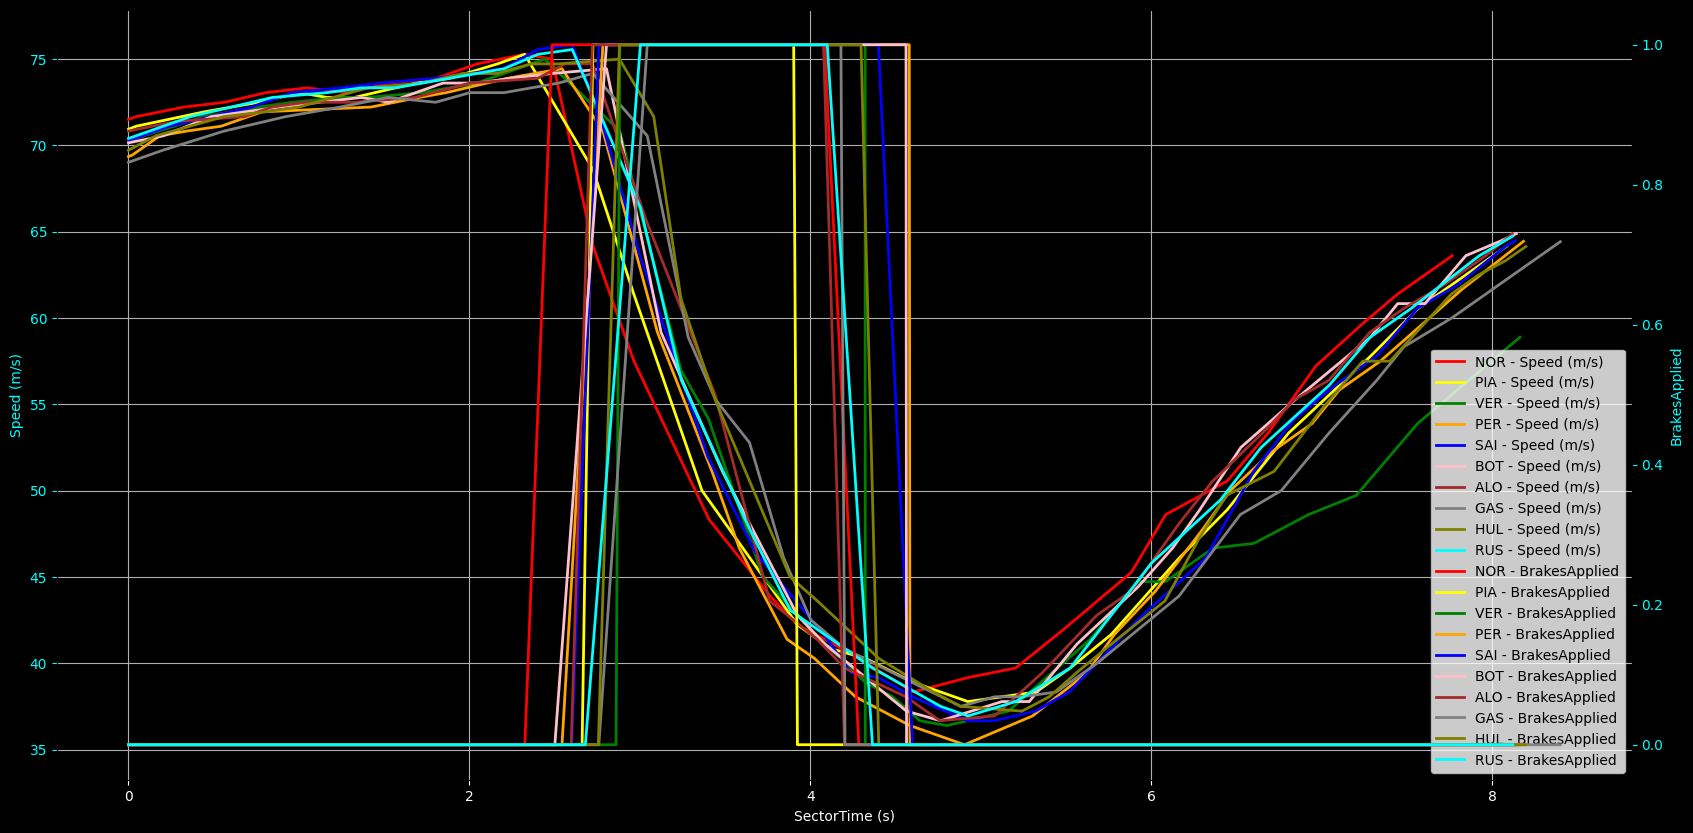

In [ ]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_fastest_q3_feature_telemetry,
        piastri_fastest_q3_feature_telemetry,
        verstappen_fastest_q3_feature_telemetry,
        perez_fastest_q3_feature_telemetry,
        sainz_fastest_q3_feature_telemetry,
        bottas_fastest_q3_feature_telemetry,
        alonso_fastest_q3_feature_telemetry,
        gasly_fastest_q3_feature_telemetry,
        hulkenberg_fastest_q3_feature_telemetry,
        russell_fastest_q3_feature_telemetry
    ],
    drivers=[
        norris, piastri, verstappen, perez, sainz, bottas, alonso, gasly, hulkenberg, russell
    ],
    telemetry_cols=[speed, brakes]
)

Plot all drivers' second fastest Q3 laps

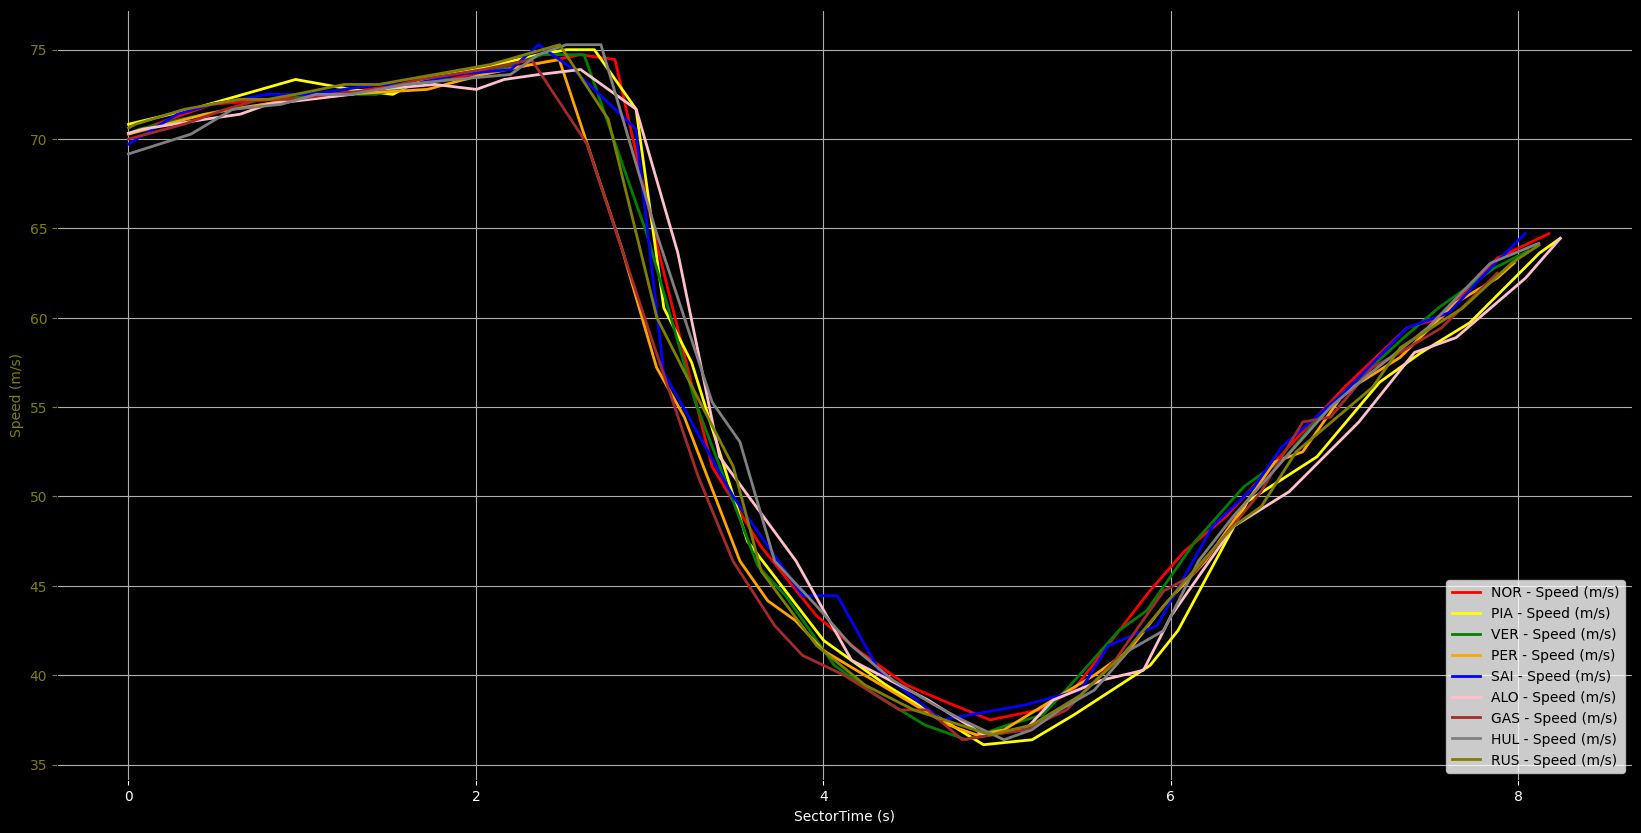

In [ ]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_second_fastest_q3_feature_telemetry,
        piastri_second_fastest_q3_feature_telemetry,
        verstappen_second_fastest_q3_feature_telemetry,
        perez_second_fastest_q3_feature_telemetry,
        sainz_second_fastest_q3_feature_telemetry,
        alonso_second_fastest_q3_feature_telemetry,
        gasly_second_fastest_q3_feature_telemetry,
        hulkenberg_second_fastest_q3_feature_telemetry,
        russell_second_fastest_q3_feature_telemetry
    ],
    drivers=[
        norris, piastri, verstappen, perez, sainz, alonso, gasly, hulkenberg, russell
    ],
    telemetry_cols=[speed]
    )

Plot all drivers' fastest Q2 laps

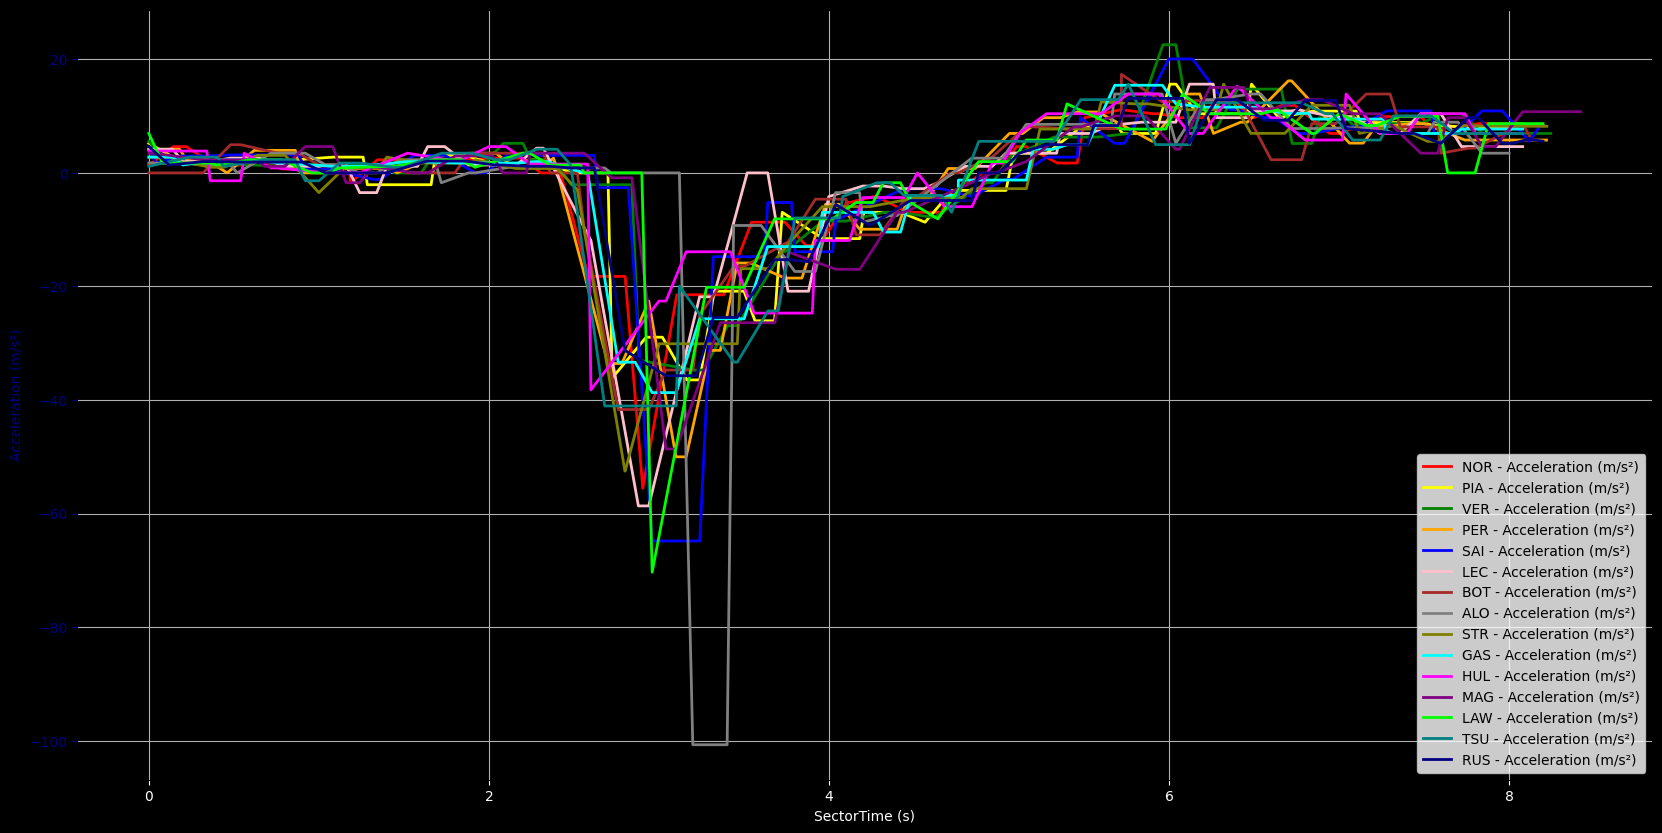

In [143]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_fastest_q2_feature_telemetry,
        piastri_fastest_q2_feature_telemetry,
        verstappen_fastest_q2_feature_telemetry,
        perez_fastest_q2_feature_telemetry,
        sainz_fastest_q2_feature_telemetry,
        leclerc_fastest_q2_feature_telemetry,
        bottas_fastest_q2_feature_telemetry,
        alonso_fastest_q2_feature_telemetry,
        stroll_fastest_q2_feature_telemetry,
        gasly_fastest_q2_feature_telemetry,
        hulkenberg_fastest_q2_feature_telemetry,
        magnussen_fastest_q2_feature_telemetry,
        lawson_fastest_q2_feature_telemetry,
        tsunoda_fastest_q2_feature_telemetry,
        russell_fastest_q2_feature_telemetry
    ],
    drivers=[
        norris, piastri, verstappen, perez, sainz, leclerc, bottas, alonso, stroll, gasly, hulkenberg, magnussen, lawson, tsunoda, russell
    ],
    telemetry_cols=[acceleration]
)

Plot all drivers' second fastest Q2 laps

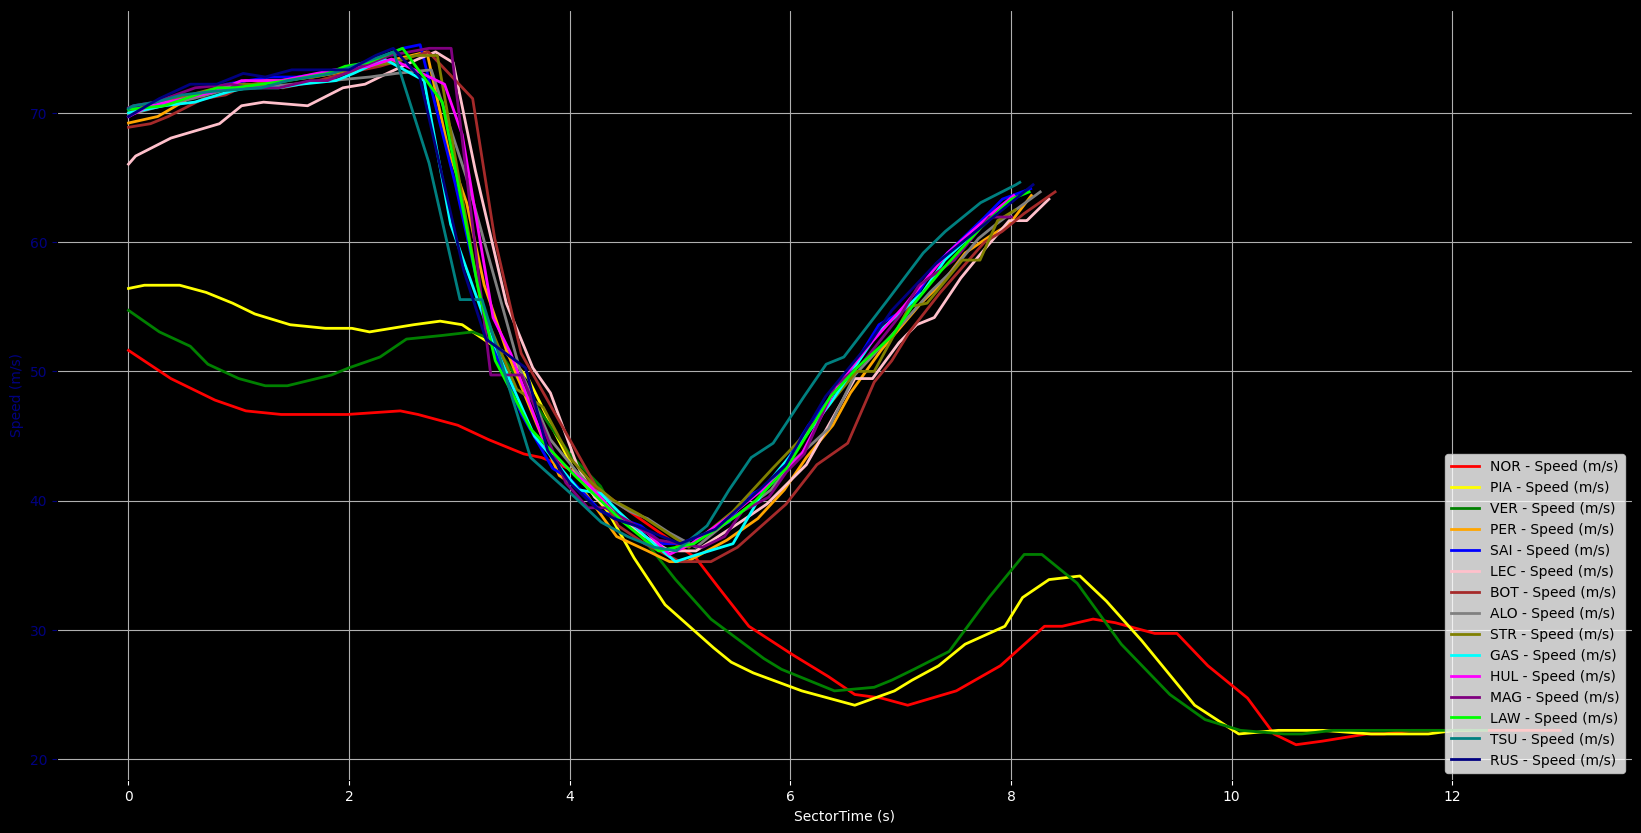

In [114]:
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_second_fastest_q2_feature_telemetry,
        piastri_second_fastest_q2_feature_telemetry,
        verstappen_second_fastest_q2_feature_telemetry,
        perez_second_fastest_q2_feature_telemetry,
        sainz_second_fastest_q2_feature_telemetry,
        leclerc_second_fastest_q2_feature_telemetry,
        bottas_second_fastest_q2_feature_telemetry,
        alonso_second_fastest_q2_feature_telemetry,
        stroll_second_fastest_q2_feature_telemetry,
        gasly_second_fastest_q2_feature_telemetry,
        hulkenberg_second_fastest_q2_feature_telemetry,
        magnussen_second_fastest_q2_feature_telemetry,
        lawson_second_fastest_q2_feature_telemetry,
        tsunoda_second_fastest_q2_feature_telemetry,
        russell_second_fastest_q2_feature_telemetry
    ],
    drivers=[
        norris, piastri, verstappen, perez, sainz, leclerc, bottas, alonso, stroll, gasly, hulkenberg, magnussen, lawson, tsunoda, russell
    ],
    telemetry_cols=[speed]
)

Key Research Questions:
1) Is there a driving style that is faster overall?
2) Which style yields higher average speed?
3) Can tire wear be correlated to a driving style? (Not yet explored in this project)

Updated Hypotheses:
1) Faster corner exits translate to greater straight-line speed and reduced lap times.
2) Drivers who re-engage full throttle at the optimal moment after the apex tend to achieve higher corner exit speeds.
3) Drivers who brake precisely at the optimal point maintain greater stability, enabling higher corner exit speeds.
4) Aggressive, late breakers are more likely to lose stability through an apex, leading to slower corner exit speeds.
5) Drivers who apply fewer braking events through a sequence of turns tend to sustain higher RPM levels, resulting in faster corner exit speeds.

New engineered features:
1) Steering Wheel Angle (will be removed as more research is required)
2) Initial Brake Timestamp
3) Max Brake Duration
4) Max Throttle Ramp Initial
5) Max Throttle Ramp Time
6) Speed at Full Throttle
7) Speed at Corner Exit
8) Speed Minimum During Turn
9) Speed Min to Exit Max
10) Turn Duration